# Here we're going to do a small train on the convgan so we can get a better idea of what our script will need

I'm borrowing ideas from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import math

from music21 import converter, instrument, note, chord, stream
import glob

from keras.utils import np_utils
import os

FONTSIZE=18
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

In [2]:
fp = open('ins_convgan_final_fantasy.pkl', "rb")
ins = pickle.load(fp)
fp.close()

In [3]:
fp = open('pitch_dict_convgan_final_fantasy.pkl', "rb")
pitch_dict = pickle.load(fp)
fp.close()

In [4]:
print(ins.shape)

(4734, 96, 96, 4)


In [5]:
class ConvGan():
    
    def __init__(self):
        
        self.image_height=ins.shape[1]
        self.image_width=ins.shape[2]
        self.num_channels=ins.shape[3]
        self.pixel_length=float(1/12)
        #offsets in music21 are given in terms of 1/4 of a measure, so a pixel_length of 1/12 is actually 1/48 of a measure
        self.measures_per_image=2
        #self.image_width=int(4*self.measures_per_image/self.pixel_length)
        
        self.D=None #discriminator
        self.G=None #generator
        self.AM=None #adversarial model
        self.DM=None #discriminator model
        
    def build_discriminator(self):
        self.D=Sequential()
        input_shape=(self.image_height,self.image_width,self.num_channels)
        
        for i in range(len(d_filters)):
            
            if i==0:
                self.D.add(Conv2D(d_filters[i],
                                  strides=2,
                                  input_shape=input_shape,
                                  activation='elu',
                                  kernel_size=(d_kernel[i],d_kernel[i]),
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='truncated_normal',
                                  bias_initializer='zeros',
                                  name='DC'+str(i),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)
                                  ))
            else:
                self.D.add(Conv2D(d_filters[i],
                                  strides=2,
                                  activation='elu',
                                  kernel_size=(d_kernel[i],d_kernel[i]),
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='truncated_normal',
                                  bias_initializer='zeros',
                                  name='DC'+str(i),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)
                                  ))
            self.D.add(Dropout(0.4))
            
        self.D.add(Flatten())
        self.D.add(Dense(1,activation='sigmoid'))
        print(self.D.summary())
        opt=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
        self.D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        
        return self.D
        
        
    def build_generator(self):
        #latent space is a vector of length 100
        self.G=Sequential()
        n_nodes=int( int(self.image_height/4)*int(self.image_width/4)*128  )
        self.G.add(Dense(n_nodes,
                         input_dim=100,
                         activation='elu',
                         ))
        #this Dense layer is an attempt to create many low resolution images from our latent space
        self.G.add(Reshape((int(self.image_height/4),int(self.image_width/4),128)))
        #next we need to upsample the low resolution images to higher resolution
        self.G.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation='elu'))
        #this will double the number of rows and the number of columns
        self.G.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation='elu'))
        #performing this operation twice brings us to the image resolution
        self.G.add(Conv2D(self.num_channels, (7,7), activation='sigmoid', padding='same'))
        print(self.G.summary())
        
        return self.G
        
        
    def build_combined(self,G,D):
        
        D.trainable=False
        
        self.C=Sequential()
        self.C.add(G)
        self.C.add(D)
        opt=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
        self.C.compile(loss='binary_crossentropy', optimizer=opt)
        
        return self.C
    def generate_latent_space(self,n_samples,latent_dim):

        xinput=np.random.randn(n_samples*latent_dim)
        xinput=xinput.reshape((n_samples,latent_dim))

        return xinput

    def generate_fake_samples(self,G,n_samples,latent_dim):

        xinput=generate_latent_space(n_samples,latent_dim)

        X=G.predict(xinput)

        y=np.zeros((n_samples,1))

        return X,y
        
        

In [7]:
def build_discriminator(d_filters,image_height=96,image_width=96,num_channels=4):
    D=Sequential()
    input_shape=(image_height,image_width,num_channels)

    for i in range(len(d_filters)):

        if i==0:
            D.add(Conv2D(d_filters[i],
                         strides=2,
                         input_shape=input_shape,
                         activation='elu',
                         kernel_size=(3,3),
                         padding='same',
                         use_bias=True,
                         kernel_initializer='truncated_normal',
                         bias_initializer='zeros',
                         name='DC'+str(i),
                         kernel_regularizer=tf.keras.regularizers.l2(0.001)
                         ))
        else:
            D.add(Conv2D(d_filters[i],
                         strides=2,
                         activation='elu',
                         kernel_size=(3,3),
                         padding='same',
                         use_bias=True,
                         kernel_initializer='truncated_normal',
                         bias_initializer='zeros',
                         name='DC'+str(i),
                         kernel_regularizer=tf.keras.regularizers.l2(0.001)
                         ))
        D.add(Dropout(0.4))

    D.add(Flatten())
    D.add(Dense(1,activation='sigmoid'))
    print(D.summary())
    opt=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
    D.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return D

D=build_discriminator(d_filters=[64,64])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DC0 (Conv2D)                 (None, 48, 48, 64)        2368      
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
DC1 (Conv2D)                 (None, 24, 24, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 36865     
Total params: 76,161
Trainable params: 76,161
Non-trainable params: 0
____________________________________________________

In [16]:
image_height=96
image_width=96
num_channels=4
def build_generator(latent_dim):
    #latent space is a vector of length 100
    model=Sequential()
    n_nodes=int( int(image_height/8)*int(image_width/8)*128  )
    model.add(Dense(n_nodes,
                     input_dim=latent_dim,
                     activation='elu',
                     ))
    #this Dense layer is an attempt to create many low resolution images from our latent space
    model.add(Reshape((int(image_height/24),int(image_width/24),128)))
    #next we need to upsample the low resolution images to higher resolution
    model.add(Conv2DTranspose(128, (12,2), strides=(12,2), padding='same',activation='elu'))
    #this will double the number of rows and the number of columns
    model.add(Conv2DTranspose(128, (2,12), strides=(2,12), padding='same',activation='elu'))
    #performing this operation three times brings us to the image resolution
    #model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation='elu'))
    
    model.add(Conv2D(num_channels, (7,7), activation='sigmoid', padding='same'))
    print(model.summary())

    return model

G=build_generator(100)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 18432)             1861632   
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 48, 8, 128)        393344    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 96, 96, 128)       393344    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 4)         25092     
Total params: 2,673,412
Trainable params: 2,673,412
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
def generate_latent_space(n_samples,latent_dim):
    
    xinput=np.random.randn(n_samples*latent_dim)
    xinput=xinput.reshape((n_samples,latent_dim))
    
    return xinput

def generate_fake_samples(G,n_samples,latent_dim):
    
    xinput=generate_latent_space(n_samples,latent_dim)
    
    X=G.predict(xinput)
    
    y=np.zeros((n_samples,1))
    
    return X,y

In [12]:
X,y=generate_fake_samples(G,10,100)
print(X.shape)

(10, 96, 96, 4)


(-0.5, 95.5, 95.5, -0.5)

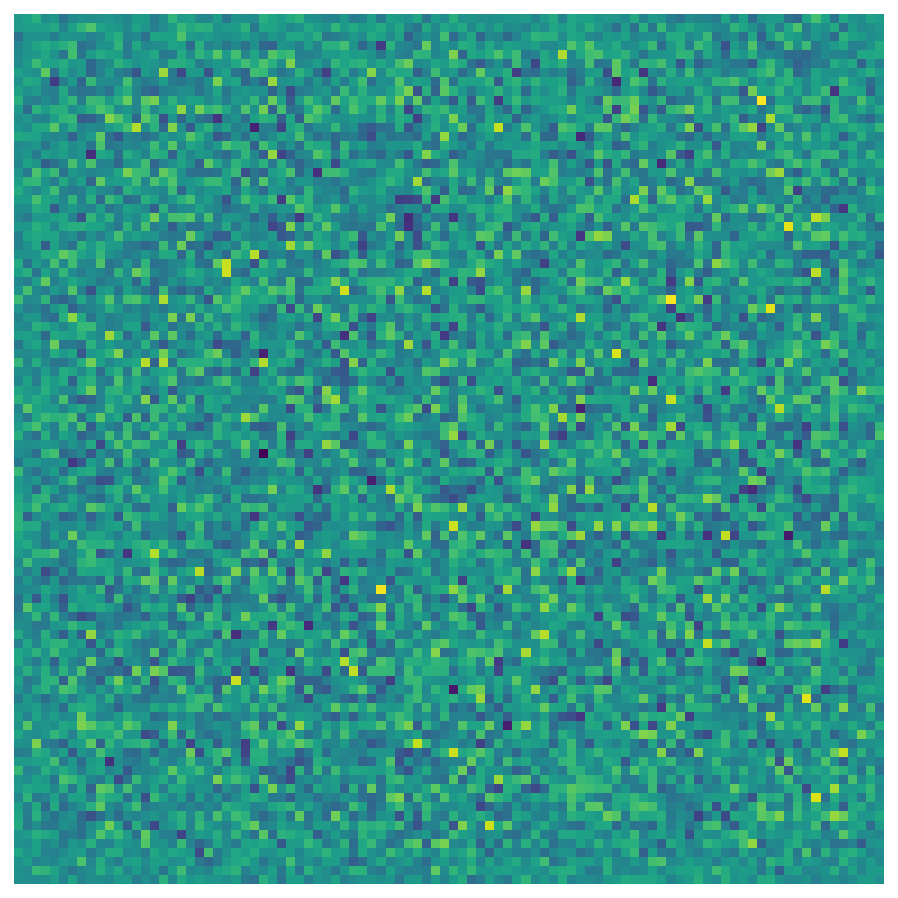

In [13]:
plt.imshow(X[0,:,:,0])
plt.axis('off')
#plt.savefig('./plots/untrained_generator.png',bbox_inches='tight')

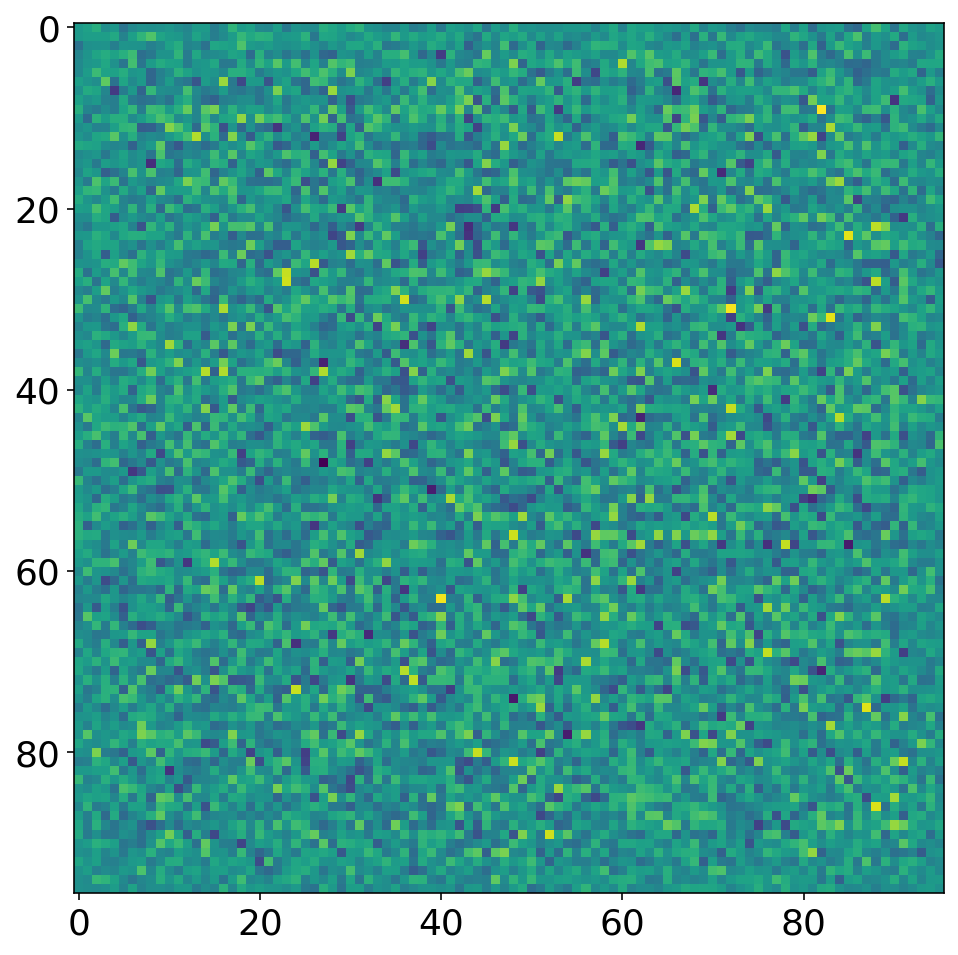

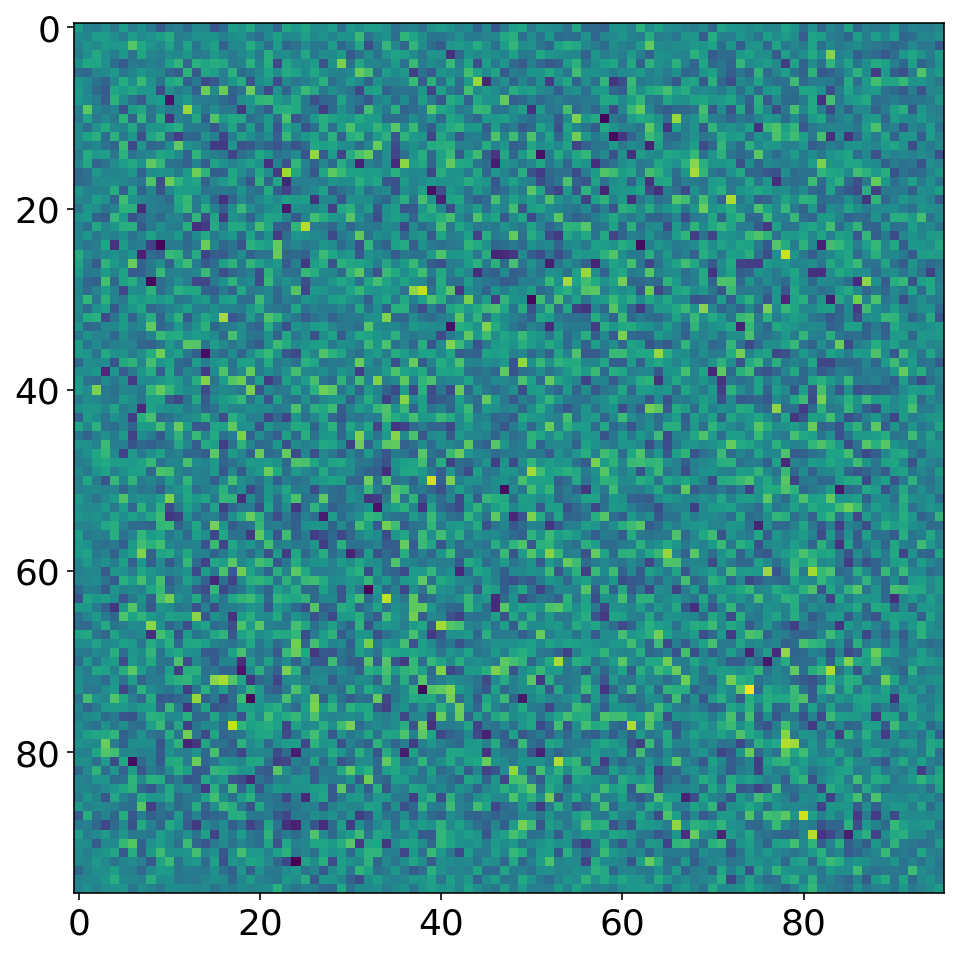

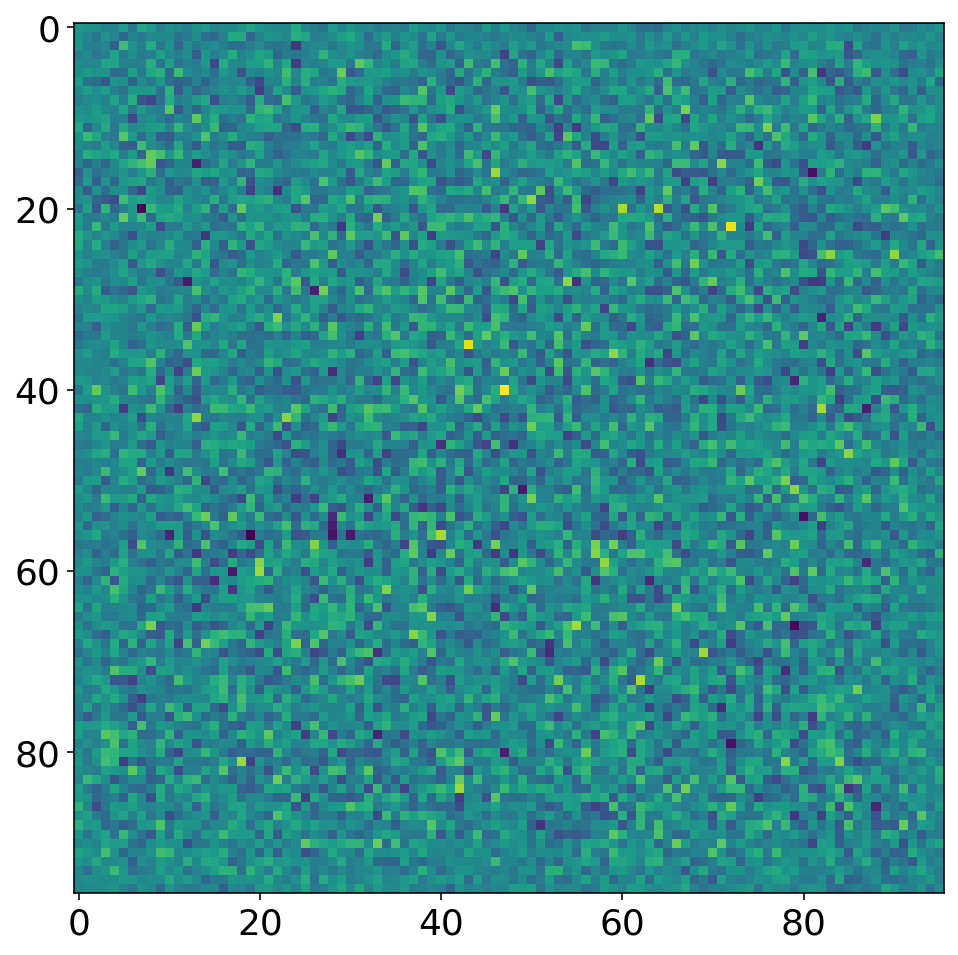

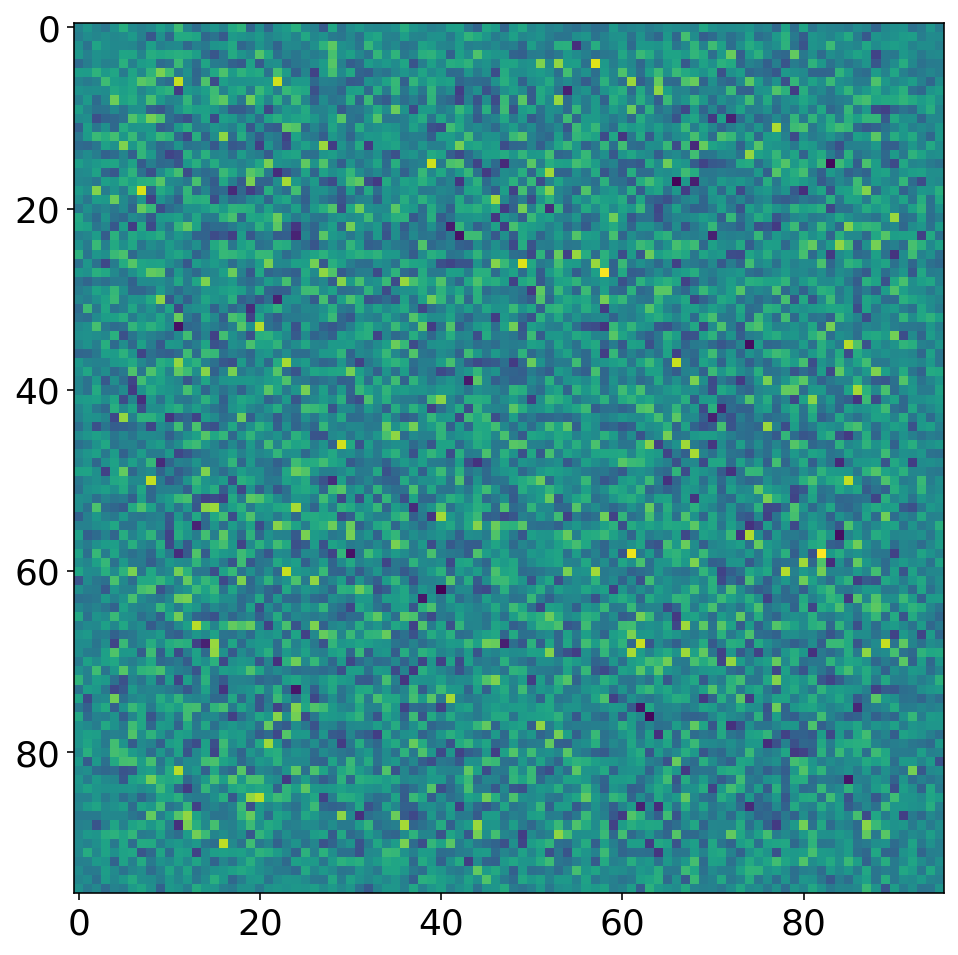

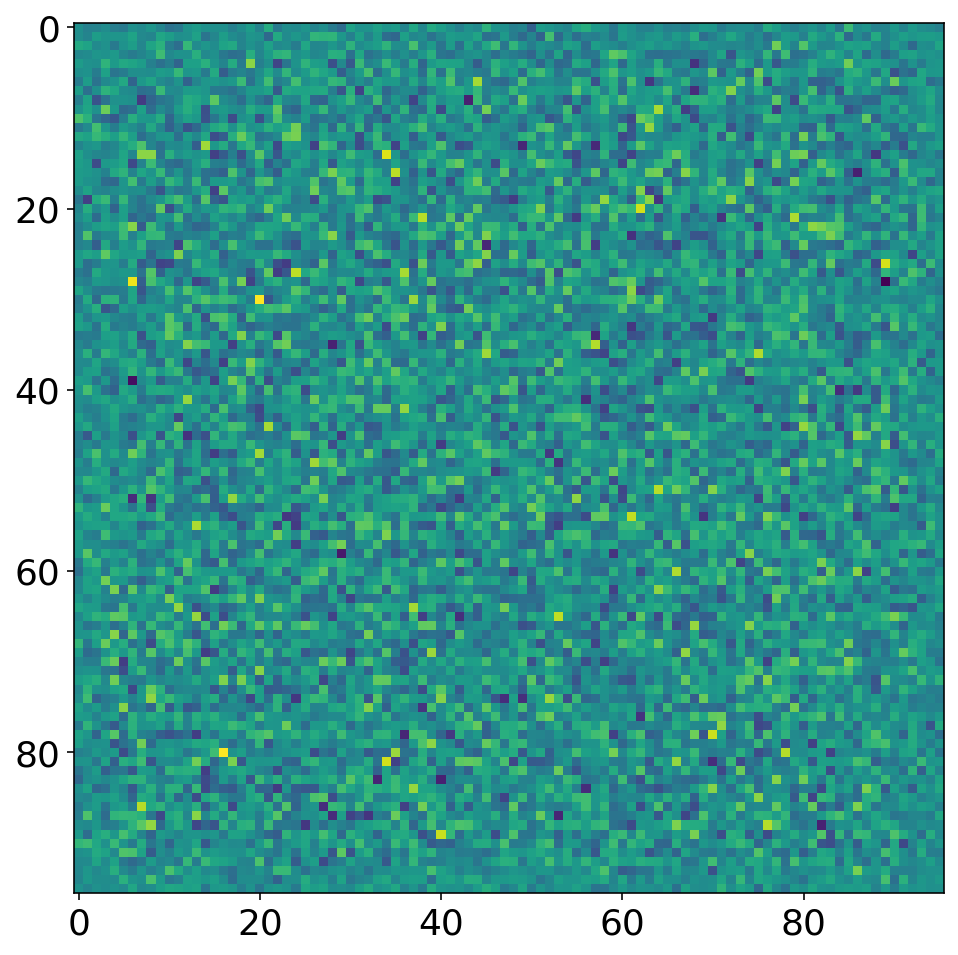

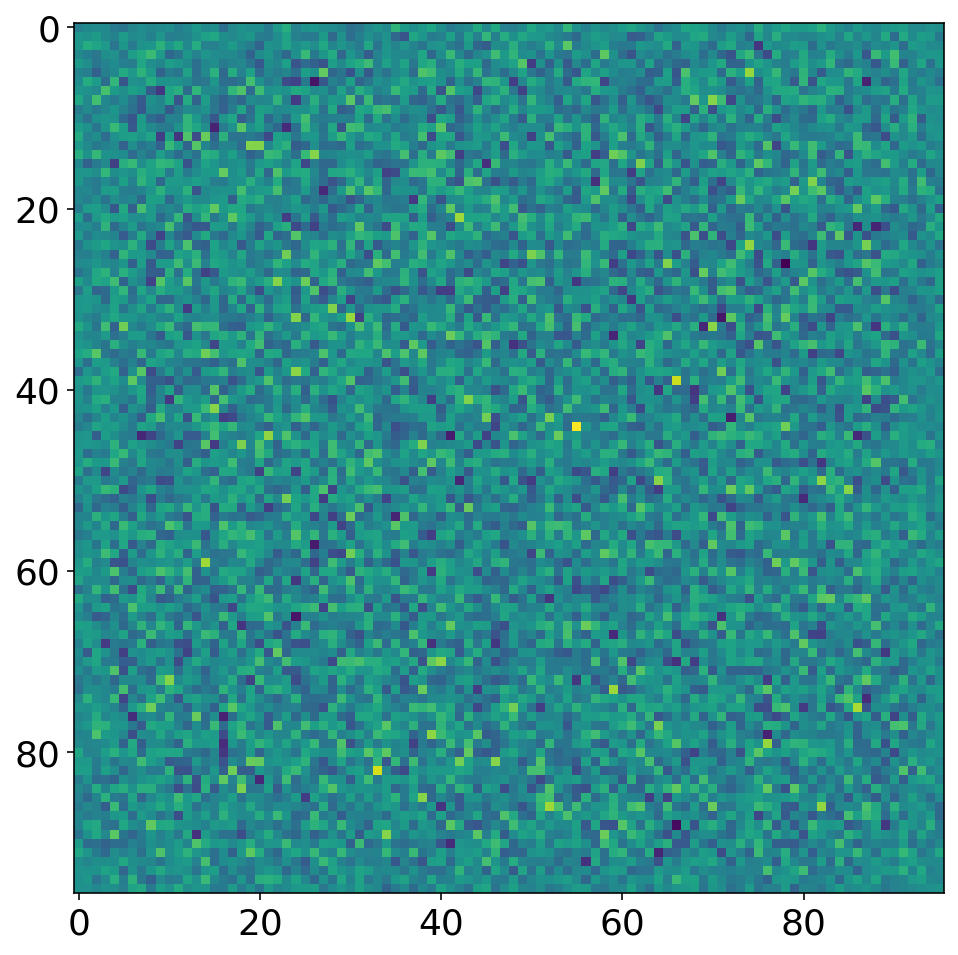

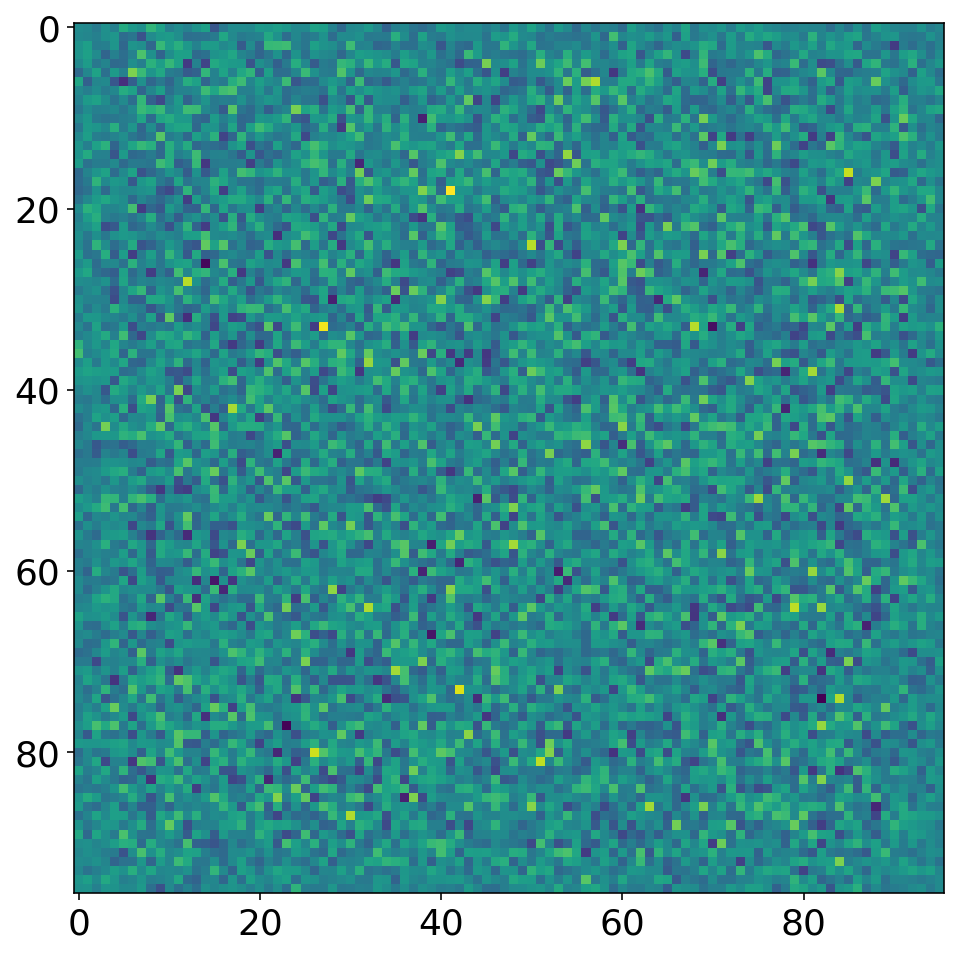

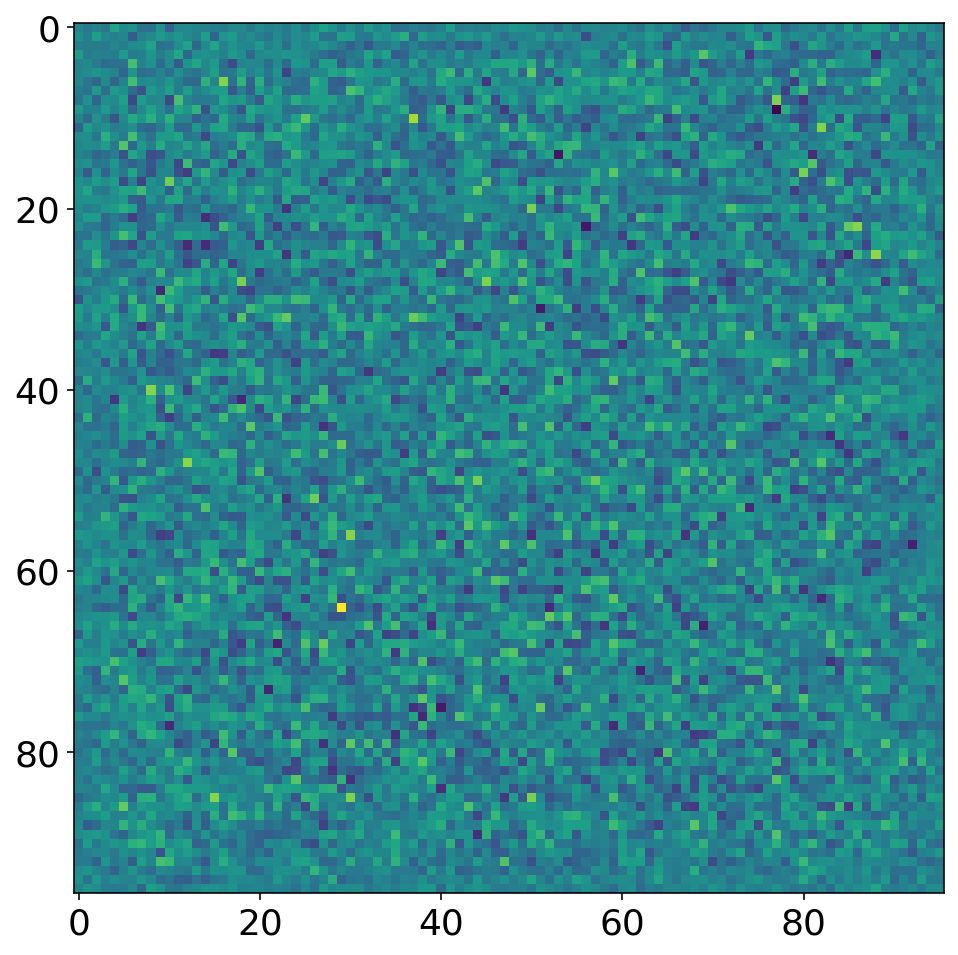

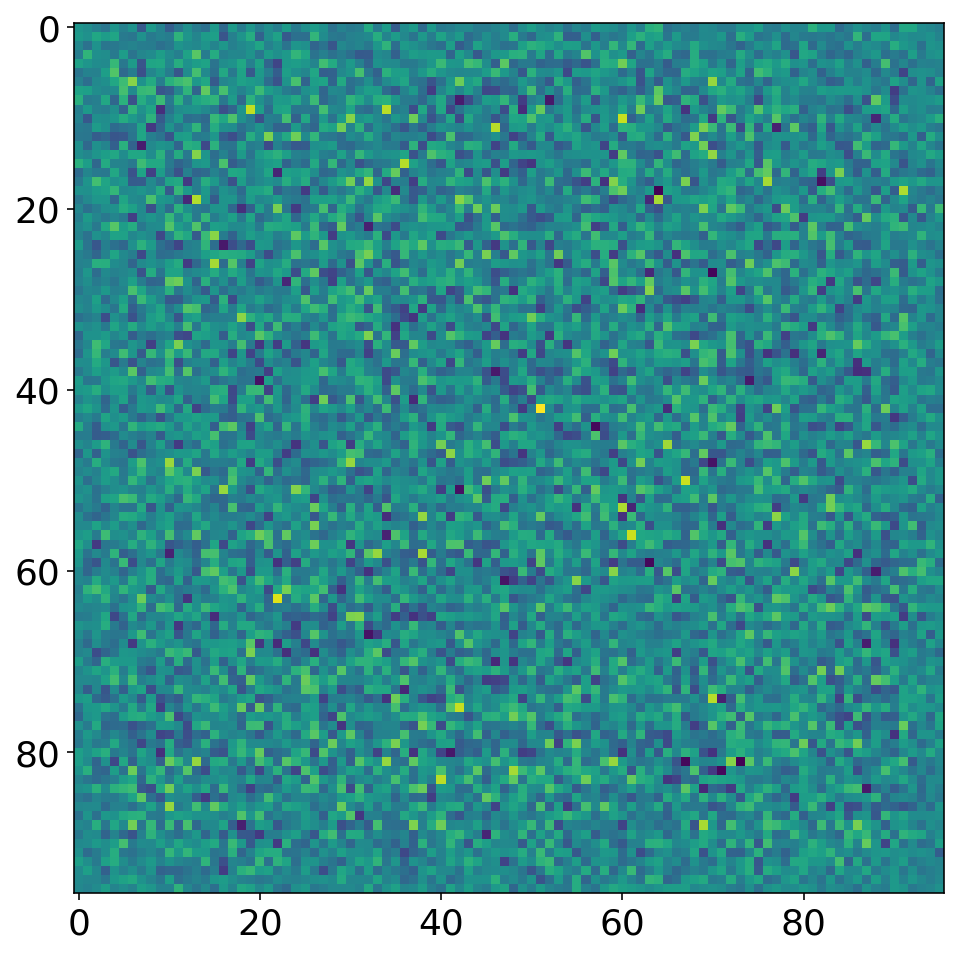

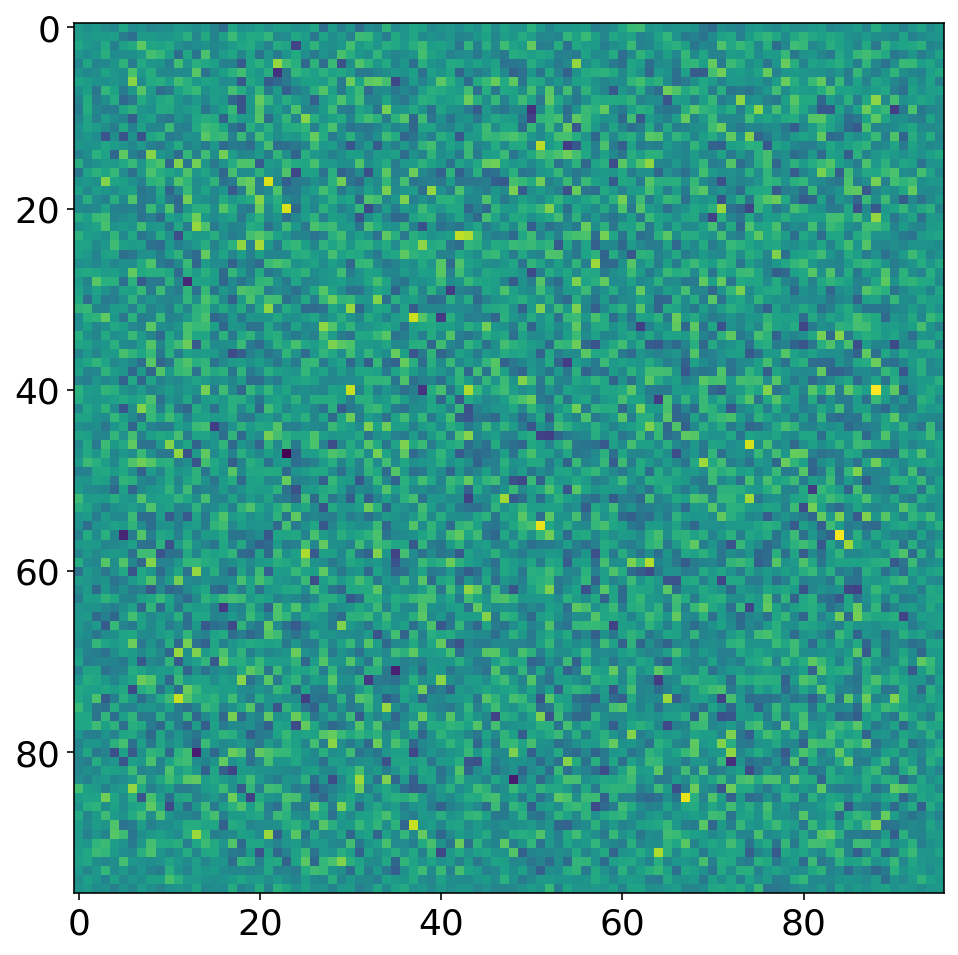

In [14]:
for i in range(10):
    plt.imshow(X[i,:,:,0])
    plt.show()

In [15]:
def build_gan(G,D):
    D.trainable=False
    
    model=Sequential()
    model.add(G)
    model.add(D)
    print(model.summary())
    opt=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return(model)

C=build_gan(G,D)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 96, 96, 4)         2673540   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 76161     
Total params: 2,749,701
Trainable params: 2,673,540
Non-trainable params: 76,161
_________________________________________________________________
None


In [16]:
#this only trains the generator
def train_gan(C,latent_dim,n_epochs=100,n_batch=256):
    for i in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        
        #even though we're producing fake data, we need the discriminator to think it's real to train our generator
        y_gan = ones((n_batch, 1))
        
        gan_model.train_on_batch(x_gan, y_gan)

In [17]:
def generate_real_samples(ins, n_samples):
    # choose random instances
    ix = np.random.randint(0, ins.shape[0], n_samples)
    # retrieve selected images
    X = ins[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [18]:
print(ins.shape)

(4734, 96, 96, 4)


In [19]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, n_samples, latent_dim)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = './results/generator_model_%03d.h5' % (epoch)
    g_model.save(filename)

In [20]:
plt.rcParams['figure.figsize']=(10,10)
def save_plot(examples, epoch, n=5):
    # plot images
    fig,axs=plt.subplots(n,n)
    count=-1
    for i in range(n):
        for j in range(n):
            count+=1
            # turn off axis
            axs[i,j].axis('off')
            # plot raw pixel data
            axs[i,j].imshow(examples[count, :, :, 0])
    # save plot to file
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    filename = './plots/generated_plot_e%03d.png' % (epoch)
    plt.savefig(filename,bbox_inches='tight')
    plt.close()

In [21]:
def train(G,D,C,ins,latent_dim,n_epochs=100,n_batch=64):
    
    d_losses=[]
    g_losses=[]

    batch_per_epoch=int(ins.shape[0]/n_batch)
    half_batch=int(n_batch/2)
    
    summarize_performance(0,G,D,ins,latent_dim)
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(ins, half_batch)
            X_fake, y_fake = generate_fake_samples(G,half_batch,latent_dim)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = D.train_on_batch(X, y)
            d_losses.append(d_loss)
            
            X_gan = generate_latent_space(n_batch,latent_dim)
            y_gan = np.ones((n_batch, 1))
            g_loss = C.train_on_batch(X_gan, y_gan)
            g_losses.append(g_loss)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
            
        if (i+1) % 1 == 0:
            summarize_performance(i+1, G, D, ins, latent_dim)
            
    return d_losses,g_losses
            
d_losses,g_losses=train(G,D,C,ins,100,n_epochs=2,n_batch=64)

>Accuracy real: 42%, fake: 100%
>1, 1/73, d=0.761, g=3.826
>1, 2/73, d=0.492, g=5.829
>1, 3/73, d=0.460, g=6.203
>1, 4/73, d=0.417, g=5.166
>1, 5/73, d=0.349, g=3.403
>1, 6/73, d=0.341, g=4.100
>1, 7/73, d=0.370, g=6.255
>1, 8/73, d=0.477, g=6.048
>1, 9/73, d=0.631, g=6.557
>1, 10/73, d=0.756, g=5.954
>1, 11/73, d=0.730, g=3.744
>1, 12/73, d=0.920, g=1.341
>1, 13/73, d=0.871, g=0.526
>1, 14/73, d=0.823, g=0.664
>1, 15/73, d=0.692, g=0.868
>1, 16/73, d=0.566, g=1.742
>1, 17/73, d=0.574, g=1.281
>1, 18/73, d=0.495, g=1.462
>1, 19/73, d=0.461, g=1.522
>1, 20/73, d=0.395, g=1.626
>1, 21/73, d=0.300, g=1.644
>1, 22/73, d=0.315, g=1.634
>1, 23/73, d=0.393, g=1.697
>1, 24/73, d=0.977, g=1.543
>1, 25/73, d=3.484, g=1.548
>1, 26/73, d=7.354, g=1.018
>1, 27/73, d=4.777, g=1.425
>1, 28/73, d=2.825, g=3.899
>1, 29/73, d=1.511, g=9.145
>1, 30/73, d=1.314, g=7.925
>1, 31/73, d=1.026, g=7.051
>1, 32/73, d=0.888, g=5.205
>1, 33/73, d=0.696, g=5.922
>1, 34/73, d=0.482, g=3.174
>1, 35/73, d=0.422, g=3.4

In [23]:
d_losses2,g_losses2=train(G,D,C,ins,100,n_epochs=2,n_batch=64)

>Accuracy real: 98%, fake: 100%
>1, 1/73, d=0.119, g=2.934
>1, 2/73, d=0.112, g=3.143
>1, 3/73, d=0.116, g=3.164
>1, 4/73, d=0.174, g=3.227
>1, 5/73, d=0.126, g=3.336
>1, 6/73, d=0.106, g=3.413
>1, 7/73, d=0.121, g=3.607
>1, 8/73, d=0.157, g=3.585
>1, 9/73, d=0.127, g=3.734
>1, 10/73, d=0.206, g=3.679
>1, 11/73, d=0.122, g=3.940
>1, 12/73, d=0.206, g=3.926
>1, 13/73, d=0.129, g=4.005
>1, 14/73, d=0.204, g=4.029
>1, 15/73, d=0.150, g=3.701
>1, 16/73, d=0.218, g=3.532
>1, 17/73, d=0.334, g=3.755
>1, 18/73, d=0.458, g=3.025
>1, 19/73, d=0.394, g=3.094
>1, 20/73, d=1.134, g=4.022
>1, 21/73, d=1.056, g=5.879
>1, 22/73, d=0.945, g=6.669
>1, 23/73, d=1.466, g=8.637
>1, 24/73, d=1.186, g=8.570
>1, 25/73, d=1.031, g=9.016
>1, 26/73, d=0.677, g=7.615
>1, 27/73, d=0.343, g=7.042
>1, 28/73, d=0.312, g=6.058
>1, 29/73, d=0.229, g=5.112
>1, 30/73, d=0.317, g=5.023
>1, 31/73, d=0.533, g=4.184
>1, 32/73, d=0.707, g=3.378
>1, 33/73, d=1.291, g=3.356
>1, 34/73, d=1.187, g=4.304
>1, 35/73, d=1.084, g=4.1

In [24]:
def combine_losses(d_losses,g_losses):
    
    d_loss_all=[]
    g_loss_all=[]
    
    for i in d_losses:
        d_loss_all.extend(i)
    for i in g_losses:
        g_loss_all.extend(i)
        
    return d_loss_all,g_loss_all

d_loss,g_loss=combine_losses([d_losses,d_losses2],[g_losses,g_losses2])

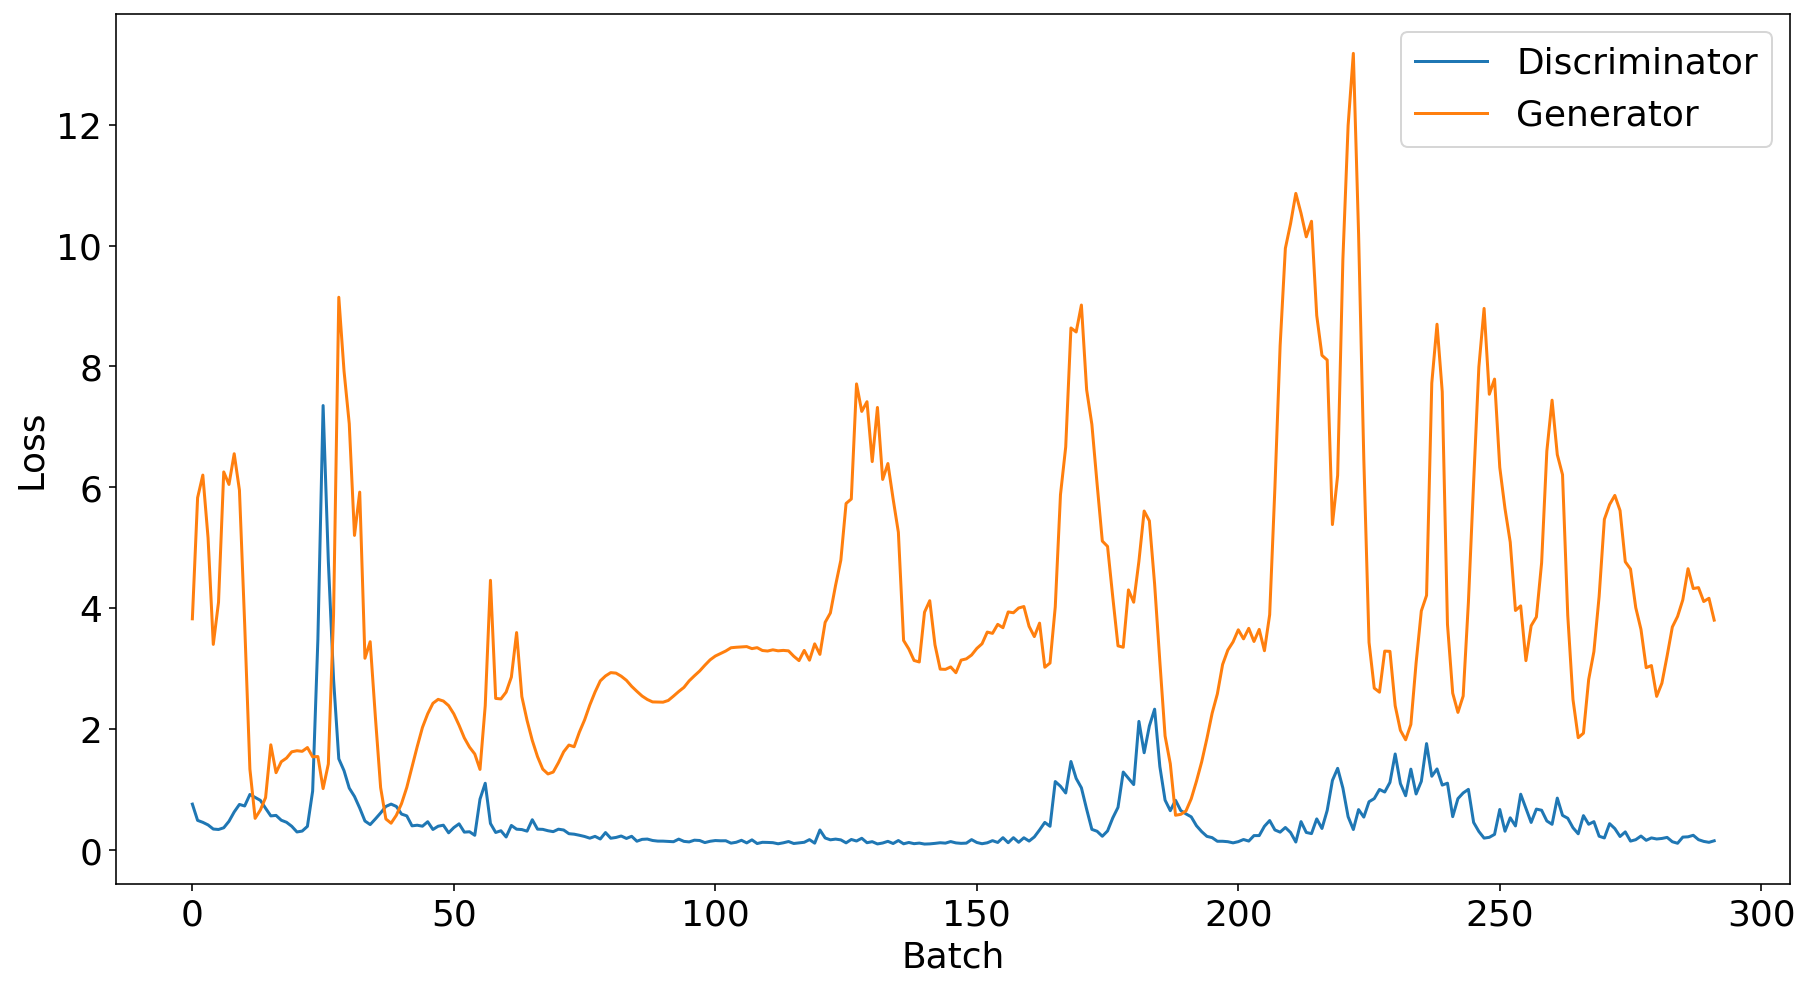

In [26]:
plt.rcParams['figure.figsize']=(15,8)
batches=np.arange(len(d_loss))
plt.plot(batches,d_loss,label='Discriminator')
plt.plot(batches,g_loss,label='Generator')
plt.legend(loc='best')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.savefig('./plots/loss1.png',bbox_inches='tight')
